<a href="https://colab.research.google.com/github/appletreeleaf/Study_Log/blob/NLP/%5BHW28_Problem%5D_Seq2seq_with_Attention_%EC%9D%B4%EC%9E%AC%EC%98%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 5: Seq2seq with Attention


*   본 실습에서는 sequence to sequence 모델을 구현하고 attention 모듈을 추가합니다.
*   seq2seq 모델은 NMT, Chatbot task에 주로 사용됩니다.


### Part 1. Seq2seq with toy example

**Part 1.1 데이터 전처리**

In [ ]:
from tqdm import tqdm
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn import functional as F

import torch
import random

`src_data`를 `trg_data`로 바꾸는 번역 task를 수행하기 위한 sample data를 준비합니다.

전체 단어 수는 100 개이고 다음과 같이 `pad token`, `start token`, `end token`의 id도 정의합니다.

In [ ]:
vocab_size = 100
pad_id = 0
sos_id = 1 # <sos> : start of sentence
eos_id = 2 # <eos> : end of sentnece

src_data = [
  [3, 77, 56, 26, 3, 55, 12, 36, 31], #[token, token, ........]
  [58, 20, 65, 46, 26, 10, 76, 44],
  [58, 17, 8],
  [59],
  [29, 3, 52, 74, 73, 51, 39, 75, 19],
  [41, 55, 77, 21, 52, 92, 97, 69, 54, 14, 93],
  [39, 47, 96, 68, 55, 16, 90, 45, 89, 84, 19, 22, 32, 99, 5],
  [75, 34, 17, 3, 86, 88],
  [63, 39, 5, 35, 67, 56, 68, 89, 55, 66],
  [12, 40, 69, 39, 49]
]

trg_data = [
  [75, 13, 22, 77, 89, 21, 13, 86, 95],
  [79, 14, 91, 41, 32, 79, 88, 34, 8, 68, 32, 77, 58, 7, 9, 87],
  [85, 8, 50, 30],
  [47, 30],
  [8, 85, 87, 77, 47, 21, 23, 98, 83, 4, 47, 97, 40, 43, 70, 8, 65, 71, 69, 88],
  [32, 37, 31, 77, 38, 93, 45, 74, 47, 54, 31, 18],
  [37, 14, 49, 24, 93, 37, 54, 51, 39, 84],
  [16, 98, 68, 57, 55, 46, 66, 85, 18],
  [20, 70, 14, 6, 58, 90, 30, 17, 91, 18, 90],
  [37, 93, 98, 13, 45, 28, 89, 72, 70]
]

In [ ]:
# target data 의 각 문장의 시작과 끝에 <sos> token id 와 <eos> token id 를 추가합니다.
trg_data = [[sos_id]+seq+[eos_id] for seq in tqdm(trg_data)]

100%|██████████| 10/10 [00:00<00:00, 54899.27it/s]


[39, 47, 96, 68, 55, 16, 90, 45, 89, 84, 19, 22, 32, 99, 5]

In [ ]:
# 각 문장의 길이를 동일하게 맞춰주기 위해 <pad> token id 를 추가하는 padding 함수를 정의합니다.
def padding(data):
  max_len = len(max(data, key=len)) # key를 len으로 하여 문장들 중 가장 긴 문장의 문장 길이를 리턴합니다.
  print(f"Maximum sequence length: {max_len}")

  valid_lens = [] # sequence lengths before padding
  for i, seq in enumerate(tqdm(data)):
    valid_lens.append(len(seq))
    if len(seq) < max_len:
      data[i] = seq + [pad_id] * (max_len - len(seq)) # seq + max_len에 못미치는 크기만큼 padding 해줌줌

  return data, valid_lens, max_len

In [ ]:
src_data, src_lens, src_max_len = padding(src_data) # max_len=15
trg_data, trg_lens, trg_max_len = padding(trg_data) # max_len=22

Maximum sequence length: 15


100%|██████████| 10/10 [00:00<00:00, 46863.73it/s]


Maximum sequence length: 22


100%|██████████| 10/10 [00:00<00:00, 64231.30it/s]


In [ ]:
# B: batch size, = 10
# S_L: source maximum sequence length, 15
# T_L: target maximum sequence length  22

# list to tensor
src_batch = torch.LongTensor(src_data)  # (B, S_L)
src_batch_lens = torch.LongTensor(src_lens)  # (B)
trg_batch = torch.LongTensor(trg_data)  # (B, T_L)
trg_batch_lens = torch.LongTensor(trg_lens)  # (B)

print(src_batch.shape)
print(src_batch_lens.shape)
print(trg_batch.shape)
print(trg_batch_lens.shape)

torch.Size([10, 15])
torch.Size([10])
torch.Size([10, 22])
torch.Size([10])


In [ ]:
src_batch_lens, sorted_idx = src_batch_lens.sort(descending=True) # sequence길이가 긴 순으로 정렬 / 통상적으로 1문장을 1sequence라고 하는지? -> task마다 다름
src_batch = src_batch[sorted_idx] # 정렬된 idx로 재정렬
trg_batch = trg_batch[sorted_idx]
trg_batch_lens = trg_batch_lens[sorted_idx]

print(src_batch)
print(src_batch_lens)
print(trg_batch)
print(trg_batch_lens)

tensor([[39, 47, 96, 68, 55, 16, 90, 45, 89, 84, 19, 22, 32, 99,  5],
        [41, 55, 77, 21, 52, 92, 97, 69, 54, 14, 93,  0,  0,  0,  0],
        [63, 39,  5, 35, 67, 56, 68, 89, 55, 66,  0,  0,  0,  0,  0],
        [ 3, 77, 56, 26,  3, 55, 12, 36, 31,  0,  0,  0,  0,  0,  0],
        [29,  3, 52, 74, 73, 51, 39, 75, 19,  0,  0,  0,  0,  0,  0],
        [58, 20, 65, 46, 26, 10, 76, 44,  0,  0,  0,  0,  0,  0,  0],
        [75, 34, 17,  3, 86, 88,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [12, 40, 69, 39, 49,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [58, 17,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [59,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
tensor([15, 11, 10,  9,  9,  8,  6,  5,  3,  1])
tensor([[ 1, 37, 14, 49, 24, 93, 37, 54, 51, 39, 84,  2,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 1, 32, 37, 31, 77, 38, 93, 45, 74, 47, 54, 31, 18,  2,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 1, 20, 70, 14,  6, 58, 90,

**Part 1.2 Encoder 구현**


*   Embedding layer, output layer, GRU cell 을 포함한 encoder 모듈을 구현합니다.



In [ ]:
embedding_size = 256
hidden_size = 512
num_layers = 2 #(foward and backwad)layer * 2
num_dirs = 2 # 2 if bidirectional=True otherwise 1
dropout = 0.1

In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_size) # words를 vocab_size만큼의 one-hot vector변환 후 embedding_size의 vector로 변환
    print(self.embedding)
    self.gru = nn.GRU(
        input_size=embedding_size, #256
        hidden_size=hidden_size,   #512
        num_layers=num_layers, # bidirection이라서 2개 인가? -> No layer는 단순 GRU층의 수임.
        bidirectional=True if num_dirs > 1 else False, # False이면 uni-direction
        dropout=dropout
    )
    self.linear = nn.Linear(num_dirs * hidden_size, hidden_size)

  def forward(self, batch, batch_lens):
    # batch: (B, S_L), batch_lens: (B)
    # d_w: word embedding size
    batch_emb = self.embedding(batch)  # (B, S_L, d_w) (batch size, sequence length(문장의 개수수), word embedding size)
    batch_emb = batch_emb.transpose(0, 1)  # (S_L, B, d_w)                 # why tranpose 0,1? -> gru 입력 형식에 관한 것 // 입력 순서랑 연관있음음 아웃풋 순서

    packed_input = pack_padded_sequence(batch_emb, batch_lens) # 이게 머지?

    h_0 = torch.zeros((num_layers * num_dirs, batch.shape[0], hidden_size))  # (num_dirs*num_layers, B, d_h) = (4, B, d_h)
    packed_outputs, h_n = self.gru(packed_input, h_0) # h_n: (4, B, d_h)
    outputs = pad_packed_sequence(packed_outputs)[0]  # outputs: (S_L, B, 2d_h) # 2d_h = bi-direction
    outputs = torch.tanh(self.linear(outputs))  # (S_L, B, d_h)

    forward_hidden = h_n[-2, :, :]
    backward_hidden = h_n[-1, :, :]
    hidden = torch.tanh(self.linear(torch.cat((forward_hidden, backward_hidden), dim=-1))).unsqueeze(0)  # (1, B, d_h)

    return outputs, hidden

In [ ]:
encoder = Encoder() # (vocab_size, embedding_size)

Embedding(100, 256)


### **Dot-product Attention 구현**
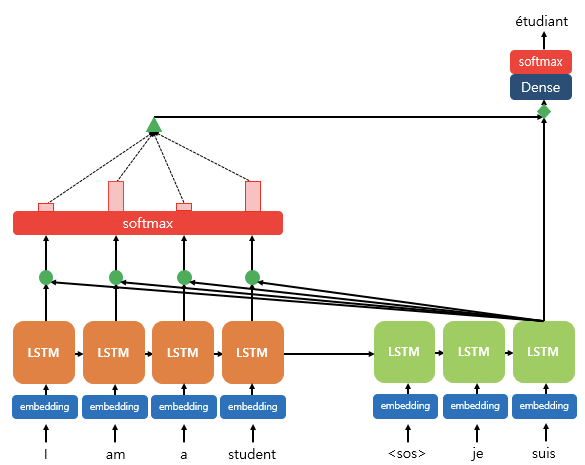

[Dot-product Attention 계산 메커니즘 복습하기](https://wikidocs.net/22893)

우선 대표적인 attention 형태 중 하나인 Dot-product Attention은 다음과 같이 구현할 수 있습니다.



In [ ]:
class DotAttention(nn.Module): ## squeeze , 크기가 1인 차원을 없애준다 ex) tensor(3,1) -> (3,) // .matmul vs .mul = 행렬곱셈 vs element-wise 곱셈
  def __init__(self):
    super().__init__()

  def forward(self, decoder_hidden, encoder_outputs):  # (1, B, d_h), (S_L, B, d_h) -> encoder_outputs은 h_1 ~ h_n까지 모든 h_i 들을 모아놓은 것이다. 그래서 S_L와 동일하다다
    query = decoder_hidden.squeeze(0)  # decoder의 hidden state, (B, d_h)
    print("query = ", query)
    key = encoder_outputs.transpose(0, 1)  # (B, S_L, d_h)
    print("key = ", key)
    print('query.unsqueeze = ', query.unsqueeze(1))
    energy = torch.sum(torch.mul(key, query.unsqueeze(1)), dim=-1)  # (B, S_L)
    print("energy = ", energy)
    attn_scores = F.softmax(energy, dim=-1)  # (B, S_L) (0.01, 0.04, 0.95....) hidden에 곱해질 가중치
    attn_values = torch.sum(torch.mul(encoder_outputs.transpose(0, 1), attn_scores.unsqueeze(2)), dim=1)  # attn_score를 가중치로하고 encoder의 hi들과 행렬연산 결과를 더해 하나의 벡터로 만듬.
                                                                                                          # 추후에 현재 시점의 h_t와 concat해서 출력층의 input이 됨.
    return attn_values, attn_scores

In [ ]:
dot_attn = DotAttention()

이제 이 attention 모듈을 가지는 Decoder 클래스를 구현하겠습니다.

In [ ]:
class Decoder(nn.Module):
  def __init__(self, attention):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.attention = attention
    self.rnn = nn.GRU(
        embedding_size,
        hidden_size
    )
    self.output_linear = nn.Linear(2*hidden_size, vocab_size)

  def forward(self, batch, encoder_outputs, hidden):  # batch: (B), encoder_outputs: (S_L, B, d_h), hidden: (1, B, d_h)
    batch_emb = self.embedding(batch)  # (B, d_w)
    batch_emb = batch_emb.unsqueeze(0)  # (1, B, d_w)   // unsqueeze -> add 1-dim to tensor

    outputs, hidden = self.rnn(batch_emb, hidden) ## TO DO ##  # (1, B, d_h), (1, B, d_h) / 각 시점당 1개의 h_i를 가진다

    attn_values, attn_scores = self.attention(hidden, encoder_outputs) ## TO DO ##  # (B, d_h), (B, S_L)
    concat_outputs = torch.cat((outputs, attn_values.unsqueeze(0)), dim=-1)  # (1, B, 2d_h) / 디코더 마지막 hidden state와 attn_value를 concat

    return self.output_linear(concat_outputs).squeeze(0), hidden  # (B, V), (1, B, d_h) # linear를 하는 이유가 뭘까? ->

In [ ]:
decoder = Decoder(dot_attn)

### **Seq2seq 모델 구축**

최종적으로 seq2seq 모델을 다음과 같이 구성할 수 있습니다.

In [ ]:
class Seq2seq(nn.Module):
  def __init__(self, encoder, decoder):
    super(Seq2seq, self).__init__()

    self.encoder = encoder
    self.decoder = decoder

  def forward(self, src_batch, src_batch_lens, trg_batch, teacher_forcing_prob=0.5):
    # src_batch: (B, S_L), src_batch_lens: (B), trg_batch: (B, T_L)

    encoder_outputs, hidden = self.encoder(src_batch, src_batch_lens)  # encoder_outputs: (S_L, B, d_h), hidden: (1, B, d_h)

    input_ids = trg_batch[:, 0]  # (B)
    batch_size = src_batch.shape[0]
    outputs = torch.zeros(trg_max_len, batch_size, vocab_size)  # (T_L, B, V)

    for t in range(1, trg_max_len):
      decoder_outputs, hidden = self.decoder(input_ids, encoder_outputs, hidden)  # decoder_outputs: (B, V), hidden: (1, B, d_h)

      outputs[t] = decoder_outputs
      _, top_ids = torch.max(decoder_outputs, dim=-1)  # top_ids: (B)

      input_ids = trg_batch[:, t] if random.random() > teacher_forcing_prob else top_ids

    return outputs

In [ ]:
seq2seq = Seq2seq(encoder, decoder)

### **모델 사용해보기**

만든 모델로 결과를 확인해보겠습니다.

In [ ]:
# V: vocab size
outputs = seq2seq(src_batch, src_batch_lens, trg_batch)  # (T_L, B, V)

print(outputs)
print(outputs.shape)

query =  tensor([[-0.0023,  0.0164, -0.0840,  ...,  0.2796,  0.0954, -0.1155],
        [-0.0577, -0.0429, -0.0815,  ...,  0.2165,  0.0779, -0.0717],
        [-0.0132, -0.0320, -0.0118,  ...,  0.2350,  0.0666, -0.0904],
        ...,
        [-0.0655,  0.0028, -0.0756,  ...,  0.2421,  0.1124, -0.0292],
        [-0.1023,  0.0531, -0.0747,  ...,  0.2657,  0.0790, -0.1512],
        [-0.0703, -0.0081, -0.0793,  ...,  0.2671,  0.0635, -0.0984]],
       grad_fn=<SqueezeBackward1>)
key =  tensor([[[-5.6753e-02,  7.7835e-02,  6.7597e-02,  ...,  6.8870e-02,
          -3.5380e-02,  1.0346e-02],
         [-5.9170e-02,  1.0494e-01,  5.2760e-02,  ...,  9.9675e-02,
          -3.0218e-02,  3.5341e-02],
         [-3.9609e-02,  1.1401e-01,  1.3867e-01,  ...,  1.0823e-01,
          -8.0849e-02,  5.7953e-02],
         ...,
         [ 4.7176e-02,  6.1462e-02, -5.8138e-02,  ..., -9.0438e-02,
          -3.8127e-03,  8.6675e-02],
         [ 4.0374e-02,  1.3714e-01, -4.5172e-04,  ..., -3.2934e-02,
          -2.

In [ ]:
sample_sent = [4, 10, 88, 46, 72, 34, 14, 51]
sample_len = len(sample_sent)

sample_batch = torch.LongTensor(sample_sent).unsqueeze(0)  # (1, S_L)
sample_batch_len = torch.LongTensor([sample_len])  # (1)

encoder_output, hidden = seq2seq.encoder(sample_batch, sample_batch_len)  # hidden: (4, 1, d_h)

In [ ]:
input_id = torch.LongTensor([sos_id]) # (1)
output = []

for t in range(1, trg_max_len):
  decoder_output, hidden = seq2seq.decoder(input_id, encoder_output, hidden)  # decoder_output: (1, V), hidden: (4, 1, d_h)

  _, top_id = torch.max(decoder_output, dim=-1)  # top_ids: (1)

  if top_id == eos_id:
    break
  else:
    output += top_id.tolist()
    input_id = top_id

query =  tensor([[-7.7660e-02, -3.6322e-02, -7.4491e-02, -3.2303e-02, -3.4902e-01,
          2.4888e-01, -9.6097e-02,  1.9475e-01,  1.9000e-02,  1.5882e-01,
         -8.3967e-02, -1.4145e-01, -1.4020e-01,  1.5887e-02,  8.4816e-02,
         -3.0260e-02, -1.7230e-01, -4.1593e-01,  1.1530e-01, -1.0051e-01,
         -9.0604e-02, -1.5776e-01, -5.9881e-02, -2.7729e-01, -1.4081e-01,
          2.1913e-01,  2.5588e-01,  7.7484e-02, -6.8222e-02,  3.7967e-01,
         -4.6214e-02,  3.0009e-01, -1.8311e-01, -3.7944e-01,  2.4975e-01,
          6.5103e-02,  2.9231e-01, -4.6403e-03, -1.9814e-01, -1.0336e-01,
          7.2030e-03,  1.7906e-01, -2.1472e-01, -1.4712e-01, -5.2085e-02,
          6.2660e-02,  2.1406e-01,  2.1543e-01,  1.1802e-01, -3.6415e-01,
         -3.2978e-01,  1.8697e-01,  1.8141e-01,  7.1618e-02, -1.6782e-01,
          3.8289e-01,  1.0954e-01, -2.0121e-01,  1.1901e-01, -1.4519e-01,
          3.5833e-01, -3.3984e-01, -1.7942e-01, -1.0465e-01,  1.4481e-01,
          2.4469e-01, -3.6956

In [ ]:
output

[47,
 78,
 80,
 69,
 80,
 19,
 94,
 93,
 1,
 58,
 58,
 58,
 33,
 79,
 68,
 59,
 62,
 62,
 62,
 11,
 25]

### **Concat Attention 구현**

Bahdanau Attention이라고도 불리는 Concat Attention을 구현해보도록 하겠습니다.  


*   `self.w`: Concat한 query와 key 벡터를 1차적으로 linear transformation.
*   `self.v`: Attention logit 값을 계산.



In [ ]:
class ConcatAttention(nn.Module):
  def __init__(self):
    super().__init__()

    self.w = nn.Linear(2*hidden_size, hidden_size, bias=False)
    self.v = nn.Linear(hidden_size, 1, bias=False)

  def forward(self, decoder_hidden, encoder_outputs):  # (1, B, d_h), (S_L, B, d_h)
    src_max_len = encoder_outputs.shape[0]

    decoder_hidden = decoder_hidden.transpose(0, 1).repeat(1, src_max_len, 1)  # (B, S_L, d_h)
    encoder_outputs = encoder_outputs.transpose(0, 1)  # (B, S_L, d_h)

    concat_hiddens = torch.cat((decoder_hidden, encoder_outputs), dim=2)  # (B, S_L, 2d_h)
    energy = torch.tanh(self.w(concat_hiddens))  # (B, S_L, d_h)

    attn_scores = F.softmax(self.v(energy), dim=1)  # (B, S_L, 1)
    attn_values = torch.sum(torch.mul(encoder_outputs, attn_scores), dim=1)  # (B, d_h)

    return attn_values, attn_scores

In [ ]:
concat_attn = ConcatAttention()

마찬가지로 decoder를 마저 구현하겠습니다.

In [ ]:
class Decoder(nn.Module):
  def __init__(self, attention):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.attention = attention
    self.rnn = nn.GRU(
        embedding_size + hidden_size, # 이전 시점의 h_(t-1)이 query로, attn_value가 t시점의 input으로 들어감
        hidden_size
    )
    self.output_linear = nn.Linear(hidden_size, vocab_size)

  def forward(self, batch, encoder_outputs, hidden):  # batch: (B), encoder_outputs: (S_L, B, d_h), hidden: (1, B, d_h)
    batch_emb = self.embedding(batch)  # (B, d_w)
    batch_emb = batch_emb.unsqueeze(0)  # (1, B, d_w)

    attn_values, attn_scores = self.attention(hidden, encoder_outputs)  # (B, d_h), (B, S_L)

    concat_emb = torch.cat((batch_emb, attn_values.unsqueeze(0)), dim=-1)  # (1, B, d_w+d_h) / Bahdanau Attention

    outputs, hidden = self.rnn(concat_emb, hidden) # (1, B, d_h), (1, B, d_h)

    return self.output_linear(outputs).squeeze(0), hidden  # (B, V), (1, B, d_h)

In [ ]:
decoder = Decoder(concat_attn)

In [ ]:
seq2seq = Seq2seq(encoder, decoder)

In [ ]:
outputs = seq2seq(src_batch, src_batch_lens, trg_batch)

print(outputs)
print(outputs.shape)

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0594, -0.0619,  0.3004,  ..., -0.0104,  0.1170,  0.1394],
         [ 0.0240, -0.0739,  0.3063,  ..., -0.0505,  0.1164,  0.1068],
         [ 0.0711,  0.0048,  0.3083,  ..., -0.0507,  0.1033,  0.1803],
         ...,
         [ 0.0583, -0.0593,  0.2918,  ..., -0.0342,  0.1183,  0.1426],
         [ 0.0358,  0.0106,  0.2900,  ..., -0.0267,  0.1212,  0.1211],
         [ 0.0363, -0.0433,  0.2827,  ..., -0.0351,  0.0753,  0.1354]],

        [[-0.2962, -0.0190,  0.3465,  ..., -0.0589,  0.2287, -0.0183],
         [ 0.1213, -0.1595,  0.2238,  ...,  0

## 개인 프로젝트를 해보자..! 주제: 광고/진짜 리뷰 검출
- 다 배우고 시작하는 것보다 일단 시작하고 그때 그때 공부하는 것이 나은 것 같다
- 매 단계마다 100% 익힐 수는 없다. 70-80 목표로 하고 계속 공부해 나가자.
- pa